<a href="https://colab.research.google.com/github/kevin-weis/relaxinc_takehome/blob/main/relax_takehome.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [17]:
engagement = pd.read_csv("/content/drive/MyDrive/relax_challenge/takehome_user_engagement.csv")

In [18]:
file = "/content/drive/MyDrive/relax_challenge/takehome_users.csv"
import chardet
with open(file, 'rb') as rawdata:
    result = chardet.detect(rawdata.read(100000))
result

{'confidence': 0.7294372453287324, 'encoding': 'ISO-8859-1', 'language': ''}

In [56]:
cols = ['object_id', 'creation_source', 'creation_time', 
        'last_session_creation_time', 'opted_in_to_mailing_list',
        'enabled_for_marketing_drip', 'org_id', 'invited_by_user_id']
users = pd.read_csv("/content/drive/MyDrive/relax_challenge/takehome_users.csv", encoding="ISO-8859-1", usecols=cols)


In [20]:
engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [57]:
users.head()

,object_id,creation_time,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [58]:
print("There were {} users and {} total logins".format(
    engagement['user_id'].nunique(), len(engagement)))

There were 8823 users and 207917 total logins


In [59]:
engagement['time_stamp'] = pd.to_datetime(
    engagement['time_stamp']
)

In [60]:
def logins_in_days(df, days=7, logins=3):
  from datetime import timedelta
  df['date'] = df['time_stamp'].dt.date
  df = df.drop_duplicates(subset='date').sort_values('date')
  passed_days = df['date'].diff(periods=logins-1)
  return any(passed_days <= timedelta(days=days))

In [61]:
adopted = engagement.groupby('user_id').apply(logins_in_days)
adopted.name = 'adopted_user'

In [62]:
print("There were {} adopted users out of {} users".format(
    sum(adopted), len(adopted)
))

There were 1656 adopted users out of 8823 users


In [63]:
users['org_id'].value_counts().head()

0    319
1    233
2    201
3    168
4    159
Name: org_id, dtype: int64

In [64]:
users['invited_by_user_id'].value_counts().head()

10741.0    13
2527.0     12
2308.0     11
1525.0     11
11770.0    11
Name: invited_by_user_id, dtype: int64

In [65]:
users = users.drop(['org_id', 'invited_by_user_id'], axis=1)

In [66]:
users['creation_time'] = pd.to_datetime(
    users['creation_time'])
users['last_session_creation_time'] = pd.to_datetime(users['last_session_creation_time'], unit='s')
users['history'] = users['last_session_creation_time'] - users['creation_time']
users['history'] = users['history'].dt.days

latest = max(users['creation_time'])
users['account_age'] = latest - users['creation_time']
users['account_age'] = users['account_age'].dt.days

users = users.drop(['creation_time', 'last_session_creation_time'], axis=1)

In [67]:
users.head()

,object_id,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,history,account_age
0,1,GUEST_INVITE,1,0,0.0,38
1,2,ORG_INVITE,0,0,136.0,196
2,3,ORG_INVITE,0,0,0.0,437
3,4,GUEST_INVITE,0,0,1.0,374
4,5,GUEST_INVITE,0,0,5.0,498


In [68]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 6 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_source             12000 non-null  object 
 2   opted_in_to_mailing_list    12000 non-null  int64  
 3   enabled_for_marketing_drip  12000 non-null  int64  
 4   history                     8823 non-null   float64
 5   account_age                 12000 non-null  int64  
dtypes: float64(1), int64(4), object(1)
memory usage: 562.6+ KB


In [69]:
users = users.set_index('object_id')
users.index.name = 'user_id'
data = pd.concat([users, adopted], axis=1, join='inner')
data['adopted_user'] = data['adopted_user'].astype(int)

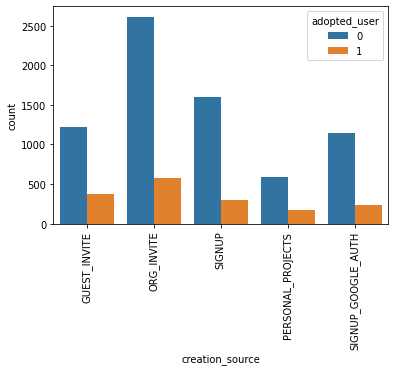

In [70]:
_ = sns.countplot(x='creation_source', data=data, hue='adopted_user')
_ = plt.xticks(rotation=90)

In [71]:
from scipy.stats import chi2_contingency
crosstab = pd.crosstab(data['creation_source'], data['adopted_user'])
results = chi2_contingency(crosstab)
print('chi2 = {}\tp = {}'.format(results[0], results[1]))

chi2 = 41.27933208242451	p = 2.3526508745340972e-08


In [72]:
data.groupby('creation_source')['adopted_user'].apply(lambda x: sum(x) / len(x))

creation_source
GUEST_INVITE          0.232368
ORG_INVITE            0.180050
PERSONAL_PROJECTS     0.225131
SIGNUP                0.159115
SIGNUP_GOOGLE_AUTH    0.172563
Name: adopted_user, dtype: float64

In [73]:
data.groupby('opted_in_to_mailing_list')['adopted_user'].apply(lambda x: sum(x) / len(x))

opted_in_to_mailing_list
0    0.185994
1    0.192722
Name: adopted_user, dtype: float64

In [74]:
def z_test(df, col, target='adopted_user'):
  from statsmodels.stats.weightstats import CompareMeans
  opted_in = df.loc[data[col] == 1, target]
  opted_out = df.loc[data[col] == 0, target]
  z_data = CompareMeans.from_data(opted_in, opted_out)
  z, p = CompareMeans.ztest_ind(z_data)
  print("For {}, z = {}, p = {}".format(col, z, p))

z_test(data, 'opted_in_to_mailing_list')

For opted_in_to_mailing_list, z = 0.7029779128148235, p = 0.4820695142048762


In [75]:
data.groupby('enabled_for_marketing_drip')['adopted_user'].apply(lambda x: sum(x)/len(x))

enabled_for_marketing_drip
0    0.186982
1    0.191648
Name: adopted_user, dtype: float64

In [76]:
z_test(data, 'enabled_for_marketing_drip')

For enabled_for_marketing_drip, z = 0.40292649500940264, p = 0.6870022995069656


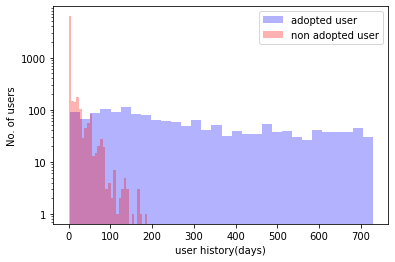

In [77]:
def plot_hist_days(df, col, xlabel):
    _ = plt.hist(df.loc[data['adopted_user']==1, col], 
                 bins=30, alpha=0.3, color='b', label='adopted user')
    _ = plt.hist(df.loc[data['adopted_user']==0, col], 
                 bins=30, alpha=0.3, color='r', label='non adopted user')
    _ = plt.yscale('log')
    _ = plt.legend()
    _ = plt.xlabel(xlabel)
    _ = plt.ylabel('No. of users')
    _ = plt.yticks([1, 10, 100, 1000], ['1', '10', '100', '1000'])
plot_hist_days(data, 'history', 'user history(days)')

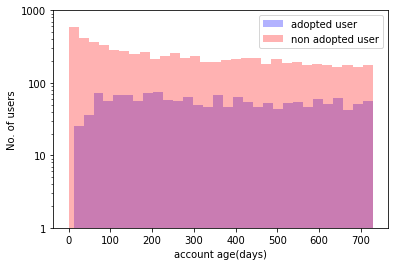

In [78]:
plot_hist_days(data, 'account_age', 'account age(days)')

In [79]:
creation_source = pd.get_dummies(data['creation_source'], drop_first=True)
model_data = pd.concat([data, creation_source], axis=1).drop('creation_source', axis=1)
y = model_data['adopted_user']
X = model_data.drop('adopted_user', axis=1)

In [80]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(
    X, y, stratify=y, random_state=42)

In [81]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
clf = RandomForestClassifier(random_state=42, class_weight='balanced')
# use CV to tune number of trees
params = {'n_estimators': [10, 50, 100, 200]}
model = GridSearchCV(clf, params)
model.fit(Xtrain, ytrain)
print('Best parameters were', model.best_params_)
print('Best average precision was', model.best_score_)

Best parameters were {'n_estimators': 50}
Best average precision was 0.962521322728487


In [82]:
from sklearn.metrics import classification_report, accuracy_score
model = RandomForestClassifier(
    random_state=42, class_weight='balanced', n_estimators=100
)
model.fit(Xtrain, ytrain)
ypred = model.predict(Xtest)
print('Accuracy of test set was', accuracy_score(ytest, ypred))
print(classification_report(ytest, ypred))

Accuracy of test set was 0.9524025385312783
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1792
           1       0.88      0.86      0.87       414

    accuracy                           0.95      2206
   macro avg       0.92      0.92      0.92      2206
weighted avg       0.95      0.95      0.95      2206



In [83]:
imp = pd.Series(model.feature_importances_, index=X.columns)
imp = imp.sort_values(ascending=False)
print(imp)

history                       0.896213
account_age                   0.088842
opted_in_to_mailing_list      0.003002
SIGNUP                        0.002919
enabled_for_marketing_drip    0.002682
ORG_INVITE                    0.002350
PERSONAL_PROJECTS             0.002069
SIGNUP_GOOGLE_AUTH            0.001923
dtype: float64
